# Filtering Out False Triggers
This notebook contains the code to filter out false triggers in batches of wildlife camera capture. We will experiment with using YOLOv5 purely "out of the box" to achieve this and evaluate the model's effectiveness at the task and its runtime.

**Note:** This notebook requires the user to have a local clone of the [YOLOv5](https://github.com/ultralytics/yolov5) Github repository. The user should first set up the dependencies for the YOLOv5 model before running this notebook. This notebook expects to be located within the root directory of the YOLOv5 repository.

## Initial Setup

In [2]:
!pip install -qr requirements.txt

In [1]:
import os
import glob
# setting directory paths and such
!pwd
# data_dir = "../../../data/"
img_dir = "100EK113/"
img_extension = ".jpg"
# img_paths = glob.glob(img_dir + f"*{img_extension}") + glob.glob(img_dir + f"*{img_extension.swapcase()}")

/home/lana-e/MIDS/W210/MIDS_W210Capstone_Fall22_FarMLife/backend/vision_model/yolov5


## Helper Functions
This section defines helper functions that will be useful for building the filtering functionality.

In [2]:
def parse_label_txt(label_filename):
    '''
    Function to parse YOLOv5 output label .txt files.
    Input: Filename for label .txt file
    Outputs:
    - pred_classes: List of ints. Predicted classes within image.
    - bboxes: List of lists. Each sub-list defines a bounding box for an object within an image.
    - confs: List of floats. Confidence interval for each classification within an image.
    Each list from the output is the same length, which is the number of detected objects within the image above the confidence threshold.
    '''
    
    import ast
    
    # reading labels txt file to parse labels
    with open(label_filename, "r") as labels:
        # initializing lists to store parsed values
        pred_classes = []
        bboxes = []
        confs = []
        # looping through each line (one line = one label)
        for label in labels:
            # parsing line
            pred_class, bbox1, bbox2, bbox3, bbox4, conf = label.split()
            # adding label info to stored lists
            pred_classes.append(ast.literal_eval(pred_class))
            bboxes.append([float(bbox1), float(bbox2), float(bbox3), float(bbox4)])
            confs.append(float(conf))
    
    return pred_classes, bboxes, confs

## Data Labeling
This section manually assigns labels to every image in our sample set to reference for training and evaluation benchmarks.

In [3]:
# hand-labeling images
empty = ["09080002", "09080003", "09080018", "09090020", "09090021", "09090023", "09090024", "09110029", "09110030", "09110032", "09110033", "09120036",
         "09140038", "09140039", "09150041", "09150042", "09150044", "09150045", "09150047", "09150048", "09150050", "09150051", "09150053", "09150054",
         "09160056", "09160057", "09160058", "09160059", "09160060", "09160061", "09160062", "09160063", "09170064", "09170065", "09170066", "09180071",
         "09180072", "09180074", "09180075", "09180076", "09180077", "09180078", "09180080", "09180081", "09200082", "09200083", "09200084", "09200089",
         "09200090", "09200092", "09200093", "09200096", "09210097", "09210098", "09210099", "09210101", "09210102", "09210103", "09210104", "09210105",
         "09220108", "09220109", "09220110", "09220111", "09220116", "09220117", "09230118", "09230119", "09230120", "09230122", "09230123", "09240125",
         "09240126", "09240132", "09240134", "09240135", "09270144", "09270146", "09270147", "09290148", "09290149", "09290150", "09290153", "09290155",
         "09290156", "09290158", "09290159", "10020177", "10020179", "10020180", "10020190", "10020191", "10020192", "10020193"]
person = ["09080001", "09080004", "09080005", "09080006", "09080007", "09080008", "09080009", "09080010", "09080011", "09080012", "09080013", "09080014",
          "09080015", "09290154", "09290157", "10020178", "10020181", "10020182", "10020183", "10020184", "10020185", "10020186", "10020187", "10020188",
          "10020189"]
vehicle = ["09080016", "09080017", "09240127", "09240128", "09240129", "09240130", "09240131", "09250136", "09250137", "09250138", "09270142", "09270143",
           "09290151", "09290152", "09300160", "09300161", "09300162", "09300163", "09300164", "09300165", "09300166", "09300167", "09300168", "09300169",
           "09300170", "09300171", "10010172", "10010173", "10010174", "10020175", "10020176"]
animal = ["09090019", "09090022", "09110025", "09110026", "09110027", "09110028", "09110031", "09120034", "09120035", "09140037", "09150040", "09150043",
          "09150046", "09150049", "09150052", "09160055", "09170067", "09170068", "09170069", "09180070", "09180073", "09180079", "09200085", "09200086",
          "09200087", "09200088", "09200091", "09200094", "09200095", "09210100", "09220106", "09220107", "09220112", "09220113", "09220114", "09220115",
          "09230121", "09240124", "09240133", "09260139", "09260140", "09260141", "09270145"]
all_labels = empty + person + vehicle + animal
objects = person + vehicle + animal

In [4]:
# checking lengths match up
print(len(all_labels))

# there is one image that is corrupted and not processed by YOLOv5 so this should be one more than the length of the labels
all_imgs = glob.glob(f"{img_dir}" + "*.JPG")
print(len(all_imgs))

all_label_files = [f"100EK113/{img_name}.JPG" for img_name in all_labels]
print(len(all_label_files))

193
194
193


In [5]:
# checking how many "empty" and how many "objects"
print(len(empty), "empty")
print(len(objects), "with objects")

94 empty
99 with objects


In [6]:
# checking for duplicates
checked = []
check = all_labels.copy()
for img_name in all_labels:
    check.remove(img_name)
    if img_name in check:
        print(img_name)

## YOLOv5 Out-of-the-Box

### Running Detection

In [23]:
# defining parameters for YOLOv5 run command (defining here so they can be easily edited)
img_size = 640 # image size, default 640
conf_thresh = 0.1 # confidence threshold, default 0.25

In [20]:
%%time
# run command for YOLOv5 base pre-trained model on image dataset
# all parameters and defaults are defined in yolov5/detect.py
'''
--weights: pre-trained model weights file
--img: image size
--conf: confidence threshold
--source: path to data directory
--save-txt: save text file for object detections in each image
--save-conf: save classification confidence in same file as save-txt
--nosave: prevent saving annotated image/video files when command is run

Note: The label .txt file has the format: "class bbox1 bbox2 bbox3 bbox4 conf"
'''
!python detect.py --weights yolov5s.pt --img $img_size --conf $conf_thresh --source $img_dir --save-txt --save-conf

detect: weights=['yolov5s.pt'], source=100EK113/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.15, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-246-ge40662f Python-3.10.8 torch-1.13.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1060 3GB, 3072MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/194 /home/lana-e/MIDS/W210/MIDS_W210Capstone_Fall22_FarMLife/backend/vision_model/yolov5/100EK113/09080001.JPG: 480x640 1 person, 11.1ms
image 2/194 /home/lana-e/MIDS/W210/MIDS_W210Capstone_Fall22_FarMLife/backend/vision_model/yolov5/100EK113/09080002.JPG: 480x640 (no detections), 23.3ms
image 3/194 /home/lana-e/MIDS/W210/MIDS_W210Capstone_Fall22_FarMLife/backe

In [11]:
# running out-of-the-box detection with different confidence thresholds for accuracy comparison
conf_thresholds = [0, 0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
# exp through exp6
for conf_thresh in conf_thresholds:
    !python detect.py --weights yolov5s.pt --img $img_size --conf $conf_thresh --source $img_dir --save-txt --save-conf

detect: weights=['yolov5s.pt'], source=../../../data/100EK113/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.0, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-205-geef9057 Python-3.10.6 torch-1.12.1+cu102 CUDA:0 (NVIDIA GeForce GTX 1060 3GB, 3072MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/174 /home/lana-e/MIDS/W210/MIDS_W210Capstone_Fall22_FarMLife/data/100EK113/09080001.JPG: 480x640 714 persons, 7 cars, 2 buss, 2 trains, 3 trucks, 18 traffic lights, 4 stop signs, 2 benchs, 38 birds, 1 elephant, 1 backpack, 12 umbrellas, 9 ties, 2 frisbees, 101 sports balls, 2 surfboards, 1 tennis racket, 37 bananas, 6 broccolis, 2 chairs, 10 potted

### Evaluating Performance

119 images with detected objects


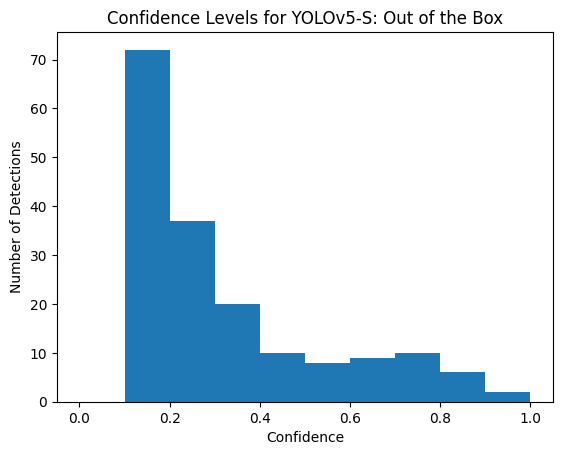

In [24]:
# histogram of confidence levels across all images in dataset
exp_num = "3"
labels_dir = f"runs/detect/exp{exp_num}/labels/*"
label_files = glob.glob(labels_dir)
print(len(label_files), "images with detected objects")

# collecting confidence levels for all classifications in every file
pred_classes = []
bboxes = []
confs = []
for label_file in label_files:
    pred_classes_i, bboxes_i, confs_i = parse_label_txt(label_file)
    pred_classes.extend(pred_classes_i)
    bboxes.extend(bboxes_i)
    confs.extend(confs_i)

# plotting histogram of confidence levels
import matplotlib.pyplot as plt
plt.hist(confs, range=(0, 1), bins=10)
plt.title("Confidence Levels for YOLOv5-S: Out of the Box")
plt.xlabel("Confidence")
plt.ylabel("Number of Detections")
plt.show()

In [25]:
# cleaning up paths to only include filename (without extensions)
pred_objects = [os.path.basename(filename)[:-4] for filename in label_files]

# creating confusion matrix
true_pos = []
true_neg = []
false_pos = []
false_neg = []

# looping through true triggers to find true positives and false negatives
for img_name in objects:
    # if image name is in pred_objects, then it is a true positive
    if img_name in pred_objects:
        true_pos.append(img_name)
    # if image name is not in pred_objects, then it is a false negative
    else:
        false_neg.append(img_name)
    
# looping through false triggers to find true negatives and false positives
for img_name in empty:
    # if image name is not in pred_objects, then it is a true negative
    if img_name not in pred_objects:
        true_neg.append(img_name)
    # if image name is in pred_objects, then it is a false positive
    else:
        false_pos.append(img_name)

# printing counts of confusion matrix
print(len(true_pos), "true positives")
print(len(true_neg), "true negatives")
print(len(false_pos), "false positives")
print(len(false_neg), "false negatives")

# calculating precision and recall
precision = len(true_pos) / (len(true_pos) + len(false_pos))
recall = len(true_pos) / (len(true_pos) + len(false_neg))
f1 = (2 * precision * recall) / (precision + recall)

print(precision, "precision")
print(recall, "recall")
print(f1, "F1")

91 true positives
66 true negatives
28 false positives
8 false negatives
0.7647058823529411 precision
0.9191919191919192 recall
0.8348623853211009 F1


----------------------
EXP_NUM: 40
173 images with detected objects


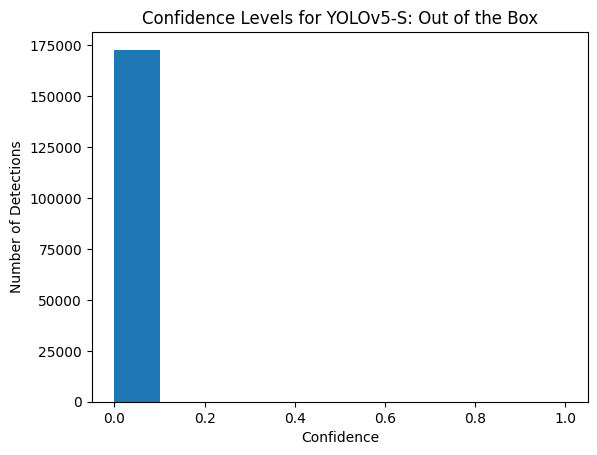

79 true positives
0 true negatives
94 false positives
20 false negatives
0.45664739884393063 precision
0.797979797979798 recall
0.5808823529411765 F1
----------------------
EXP_NUM: 41
171 images with detected objects


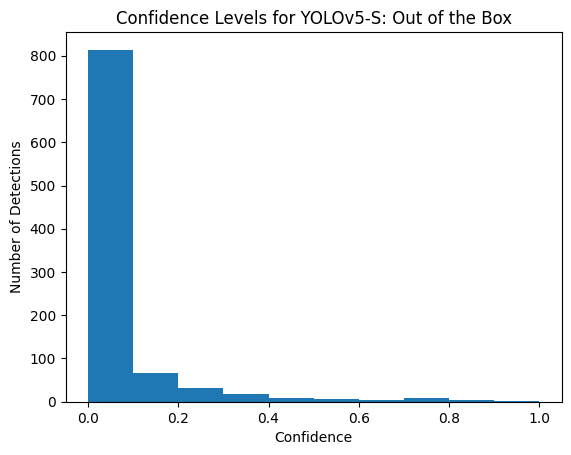

79 true positives
2 true negatives
92 false positives
20 false negatives
0.4619883040935672 precision
0.797979797979798 recall
0.5851851851851851 F1
----------------------
EXP_NUM: 42
99 images with detected objects


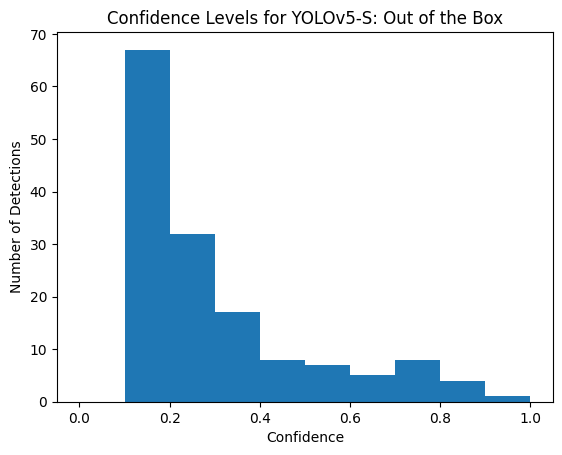

71 true positives
66 true negatives
28 false positives
28 false negatives
0.7171717171717171 precision
0.7171717171717171 recall
0.7171717171717171 F1
----------------------
EXP_NUM: 43
87 images with detected objects


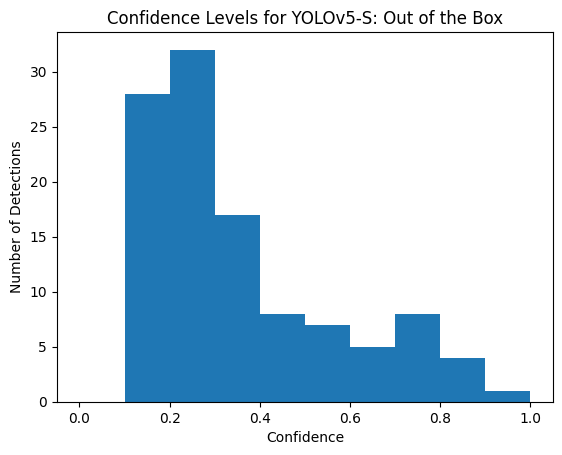

65 true positives
72 true negatives
22 false positives
34 false negatives
0.7471264367816092 precision
0.6565656565656566 recall
0.6989247311827956 F1
----------------------
EXP_NUM: 44
65 images with detected objects


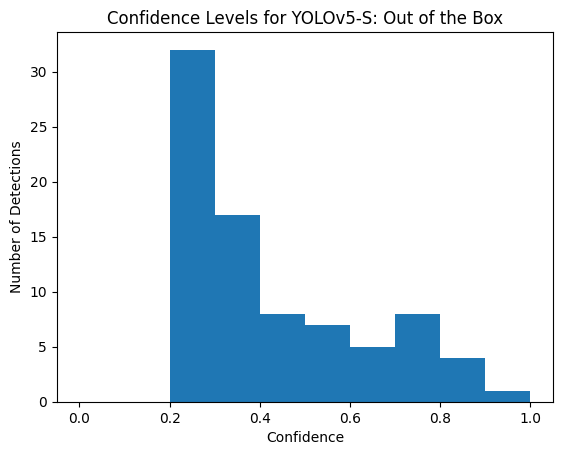

59 true positives
88 true negatives
6 false positives
40 false negatives
0.9076923076923077 precision
0.5959595959595959 recall
0.7195121951219511 F1
----------------------
EXP_NUM: 45
50 images with detected objects


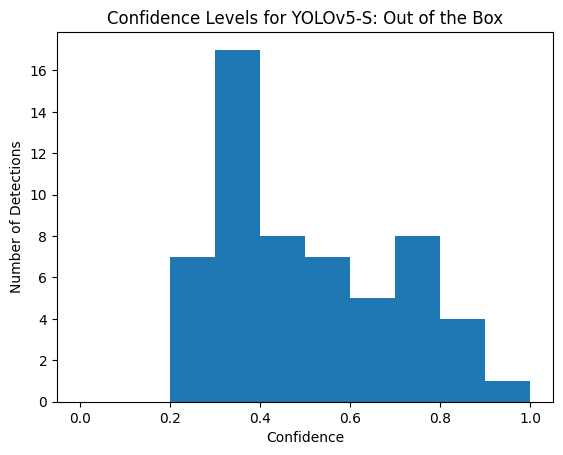

50 true positives
94 true negatives
0 false positives
49 false negatives
1.0 precision
0.5050505050505051 recall
0.6711409395973155 F1
----------------------
EXP_NUM: 46
44 images with detected objects


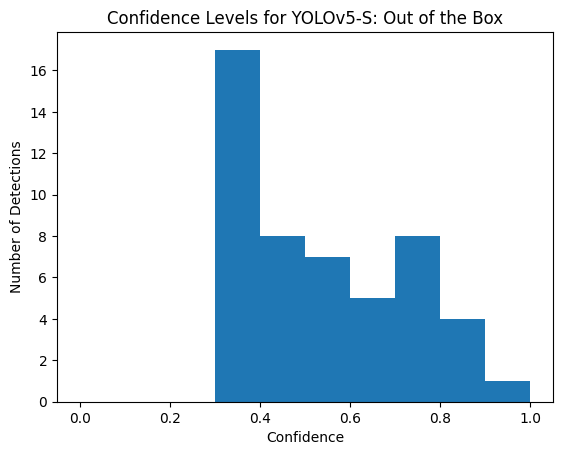

44 true positives
94 true negatives
0 false positives
55 false negatives
1.0 precision
0.4444444444444444 recall
0.6153846153846153 F1
----------------------
EXP_NUM: 47
37 images with detected objects


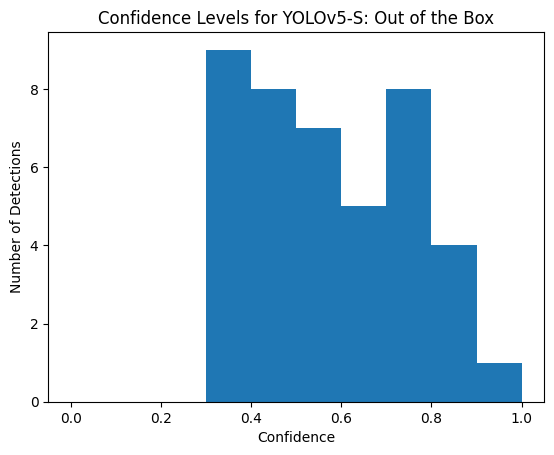

37 true positives
94 true negatives
0 false positives
62 false negatives
1.0 precision
0.37373737373737376 recall
0.5441176470588236 F1
----------------------
EXP_NUM: 48
32 images with detected objects


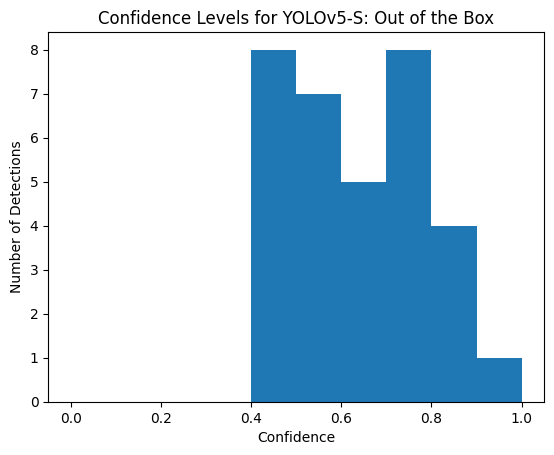

32 true positives
94 true negatives
0 false positives
67 false negatives
1.0 precision
0.32323232323232326 recall
0.4885496183206107 F1
----------------------
EXP_NUM: 49
28 images with detected objects


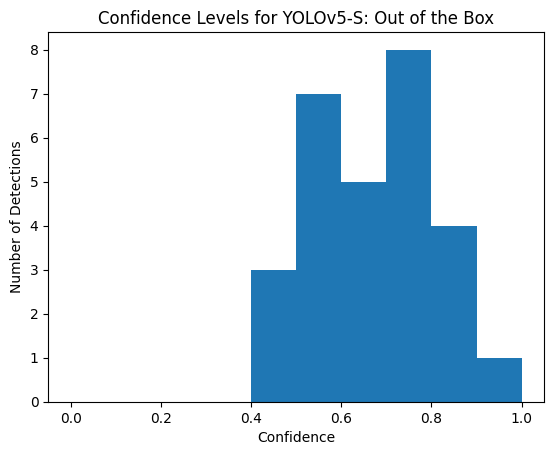

28 true positives
94 true negatives
0 false positives
71 false negatives
1.0 precision
0.2828282828282828 recall
0.4409448818897638 F1
----------------------
EXP_NUM: 50
25 images with detected objects


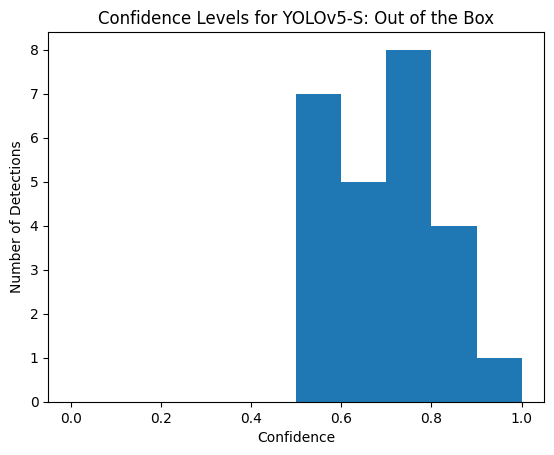

25 true positives
94 true negatives
0 false positives
74 false negatives
1.0 precision
0.25252525252525254 recall
0.40322580645161293 F1


In [12]:
# loop to evaluate 12 different confidence thresholds
exps = ["40", "41", "42", "43", "44", "45", "46", "47", "48", "49", "50"]
precisions = []
recalls = []
f1s = []
for exp_num in exps:
    print("----------------------")
    print("EXP_NUM:", exp_num)
    labels_dir = f"runs/detect/exp{exp_num}/labels/*"
    label_files = glob.glob(labels_dir)
    print(len(label_files), "images with detected objects")

    # collecting confidence levels for all classifications in every file
    pred_classes = []
    bboxes = []
    confs = []
    for label_file in label_files:
        pred_classes_i, bboxes_i, confs_i = parse_label_txt(label_file)
        pred_classes.extend(pred_classes_i)
        bboxes.extend(bboxes_i)
        confs.extend(confs_i)

    # plotting histogram of confidence levels
    import matplotlib.pyplot as plt
    plt.hist(confs, range=(0, 1), bins=10)
    plt.title("Confidence Levels for YOLOv5-S: Out of the Box")
    plt.xlabel("Confidence")
    plt.ylabel("Number of Detections")
    plt.show()
    
    # cleaning up paths to only include filename (without extensions)
    pred_objects = [os.path.basename(filename)[:-4] for filename in label_files]

    # creating confusion matrix
    true_pos = []
    true_neg = []
    false_pos = []
    false_neg = []

    # looping through true triggers to find true positives and false negatives
    for img_name in objects:
        # if image name is in pred_objects, then it is a true positive
        if img_name in pred_objects:
            true_pos.append(img_name)
        # if image name is not in pred_objects, then it is a false negative
        else:
            false_neg.append(img_name)

    # looping through false triggers to find true negatives and false positives
    for img_name in empty:
        # if image name is not in pred_objects, then it is a true negative
        if img_name not in pred_objects:
            true_neg.append(img_name)
        # if image name is in pred_objects, then it is a false positive
        else:
            false_pos.append(img_name)

    # printing counts of confusion matrix
    print(len(true_pos), "true positives")
    print(len(true_neg), "true negatives")
    print(len(false_pos), "false positives")
    print(len(false_neg), "false negatives")

    # calculating precision and recall
    precision = len(true_pos) / (len(true_pos) + len(false_pos))
    precisions.append(precision)
    recall = len(true_pos) / (len(true_pos) + len(false_neg))
    recalls.append(recall)
    f1 = (2 * precision * recall) / (precision + recall)
    f1s.append(f1)

    print(precision, "precision")
    print(recall, "recall")
    print(f1, "F1")

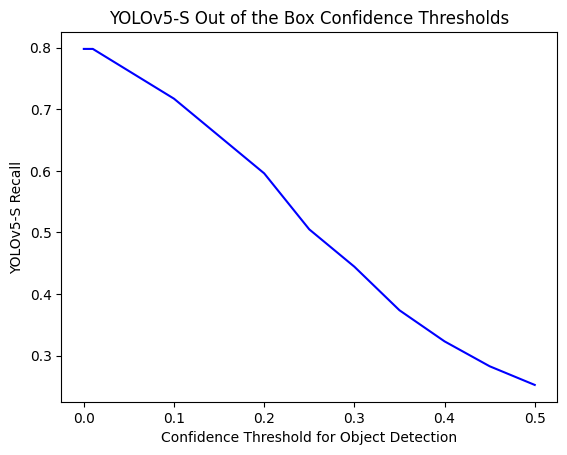

In [15]:
plt.plot(conf_thresholds, recalls, "b-")
plt.title("YOLOv5-S Out of the Box Confidence Thresholds")
plt.xlabel("Confidence Threshold for Object Detection")
plt.ylabel("YOLOv5-S Recall")
plt.savefig("ootb_recall.png", bbox_inches="tight")
plt.show()

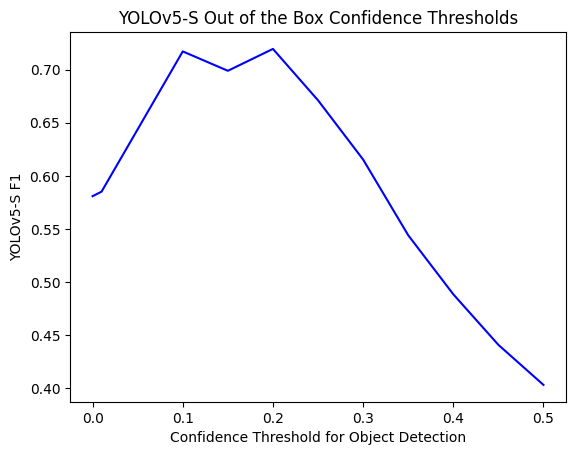

In [16]:
plt.plot(conf_thresholds, f1s, "b-")
plt.title("YOLOv5-S Out of the Box Confidence Thresholds")
plt.xlabel("Confidence Threshold for Object Detection")
plt.ylabel("YOLOv5-S F1")
plt.savefig("ootb_f1.png", bbox_inches="tight")
plt.show()